# Exercise

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

This edition of "get your hands dirty" is very open ended. You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc.

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV

To start, I download the file and I save the data.

In [2]:
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')

with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

data = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

# Read headers
with open("Summary_table.txt", 'r') as f:
    names = np.array([n.strip().replace(" ", "_") 
                     for n in f.readlines()[1].replace("#", "").replace("\n", "").lstrip().split('    ') if n.strip()!=''])

In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

I save in two different arrays ($T90$ and $T90\_err$) the values of the duration of the time interval during which $90\%$ of the GRB photon counts are observed (starting at $5\%$ and ending at $95\%$) and the errors. The values corresponding to $-999$ are not defined, thus I don't consider them.

In [4]:
T90 = np.array(data[6], dtype=float)
T90_err = np.array(data[7], dtype=float)

condition = (T90>-999)

T90 = T90[condition]
T90_err = T90_err[condition]

I want to study $T_{90}$. To do that, I start by plotting the histogram of $T90$. Because from this plot I can't see any distinction between long and short GRBs, I set a logarithmic scale on the x-axes.

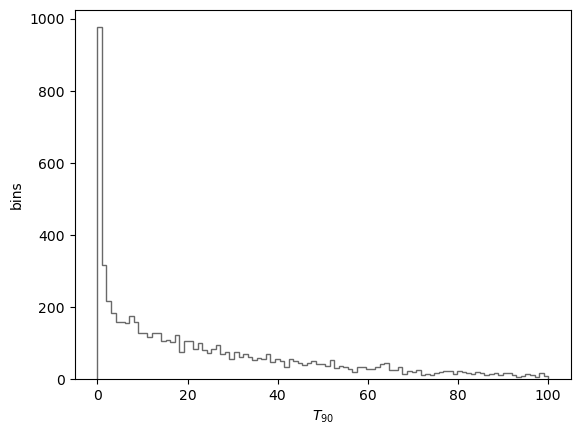

In [5]:
plt.hist(T90, bins=np.linspace(0, 100, 100), histtype='step', color='dimgrey')
plt.xlabel(r'$T_{90}$')
plt.ylabel('bins')
plt.show()

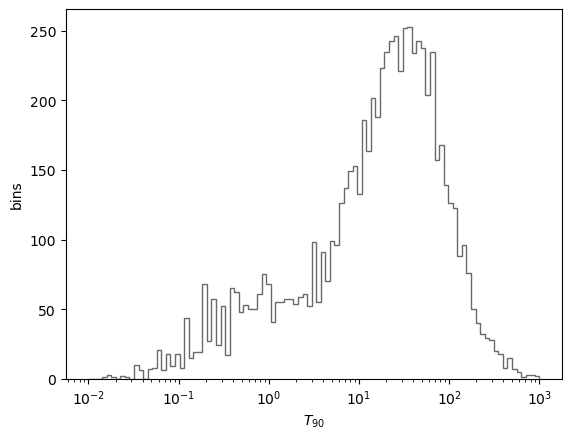

In [6]:
plt.hist(T90, bins=np.logspace(-2, 3, 100), histtype='step', color='dimgrey')
plt.xlabel(r'$T_{90}$')
plt.ylabel('bins')
plt.semilogx()
plt.show()

As I can see, there is a bimodal distribution: GRBs are divided into two categories based on their burst's duration.

I try to fit the data with a Gaussian mixture model with two components.

In [7]:
logT90 = np.log10(T90)
LT90 = logT90[:, np.newaxis]

gm = GaussianMixture(n_components=2, random_state=0).fit(LT90)

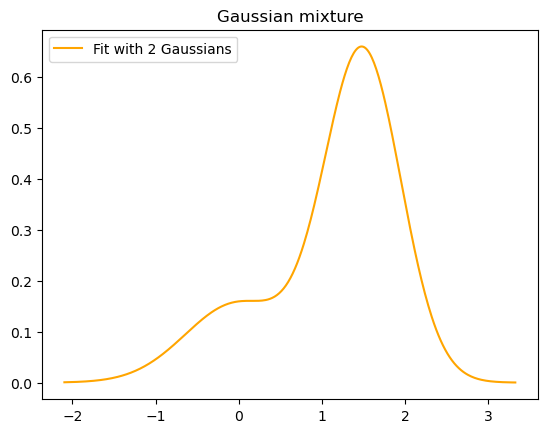

In [8]:
M = 400
x = np.linspace(LT90.min(), LT90.max(), M)

plt.plot(x, np.exp(gm.score_samples(x[:, np.newaxis])), label='Fit with 2 Gaussians', color='orange')
plt.legend()
plt.title('Gaussian mixture')
plt.show()

I compute the AIC for the Gaussian mixture model by using a number of components that ranges between $1$ and $7$. Then, I scatter the value of the AIC as a function of the number of components.

In [9]:
Numbers = [1, 2, 3, 4, 5, 6, 7]
AIC_matrix = []

for n in Numbers:
    gm2 = GaussianMixture(n_components=n, random_state=0).fit(LT90)
    AIC_matrix.append(gm2.aic(LT90))

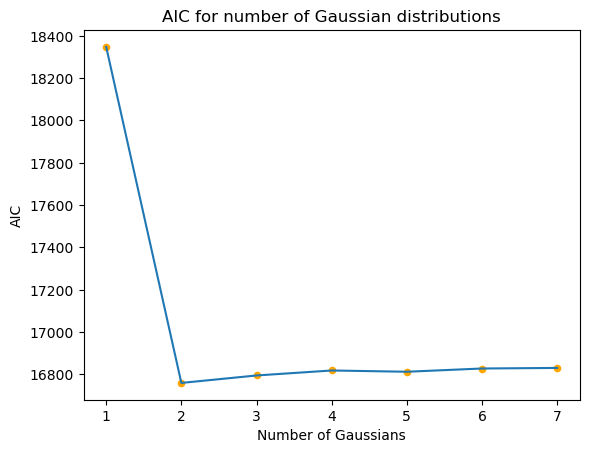

In [10]:
plt.scatter(Numbers, AIC_matrix, color='orange', s=20)
plt.plot(Numbers, AIC_matrix)
plt.xlabel('Number of Gaussians')
plt.ylabel('AIC')
plt.title('AIC for number of Gaussian distributions')
plt.show()

As I can see, the model with minimum AIC is the one that consider two Gaussian distributions, as expected. For completeness, I compare the AIC for two components with the one with three components. The AIC for $N=2$ is smaller than the one for $N=3$, moreover the simplest model is the favoured one.

In [11]:
# print the AIC for n=2 and n=3

print('AIC for 2 Gaussian distributions: ', AIC_matrix[1])
print('AIC for 3 Gaussian distributions: ', AIC_matrix[2])
print('Difference between the two AICs: ', abs(AIC_matrix[1]-AIC_matrix[2]))

AIC for 2 Gaussian distributions:  16760.014269288455
AIC for 3 Gaussian distributions:  16795.205002871913
Difference between the two AICs:  35.190733583458496


Therefore, the best fit is the one with two Gaussian distributions.

In [12]:
# comparison between n=2 and n=3
gm3 = GaussianMixture(n_components=3, random_state=0).fit(LT90)

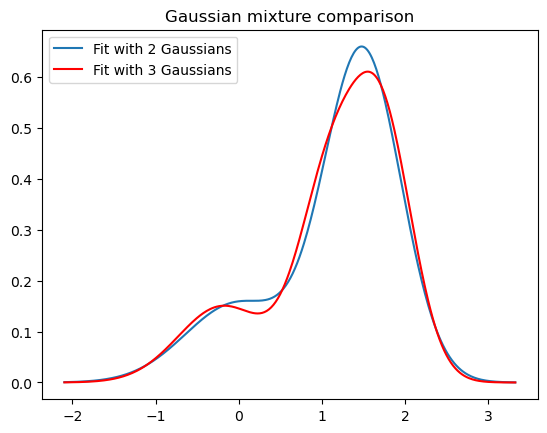

In [13]:
plt.plot(x, np.exp(gm.score_samples(x[:, np.newaxis])), label='Fit with 2 Gaussians')
plt.plot(x, np.exp(gm3.score_samples(x[:, np.newaxis])), label='Fit with 3 Gaussians', color='red')
plt.legend()
plt.title('Gaussian mixture comparison')
plt.show()

Let's analyse the distribution with a KDE process. To do that, I start with a cross-validation process to find the optimal bandwidth for the Kernel Density estimation. I do that by defining an array of $30$ bandwidths in the range $[0.01, \, 1.0]$.

In [14]:
bValues = np.linspace(0.01, 1.0, 30)
print(bValues)

[0.01       0.04413793 0.07827586 0.11241379 0.14655172 0.18068966
 0.21482759 0.24896552 0.28310345 0.31724138 0.35137931 0.38551724
 0.41965517 0.4537931  0.48793103 0.52206897 0.5562069  0.59034483
 0.62448276 0.65862069 0.69275862 0.72689655 0.76103448 0.79517241
 0.82931034 0.86344828 0.89758621 0.93172414 0.96586207 1.        ]


In [15]:
K = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': bValues}, cv=K)
grid.fit(LT90)
h_opt = grid.best_params_['bandwidth']

In [16]:
KDE = KernelDensity(kernel='gaussian', bandwidth=h_opt).fit(LT90)

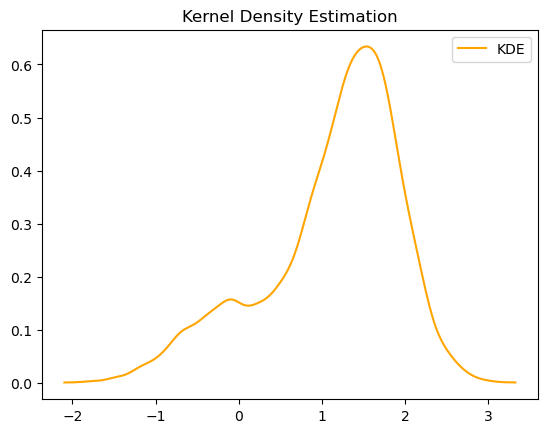

In [17]:
plt.plot(x, np.exp(KDE.score_samples(x[:, np.newaxis])), label='KDE', color='orange')
plt.legend()
plt.title('Kernel Density Estimation')
plt.show()

In [18]:
print(f'The optimal bandwidth value is: {h_opt}')

The optimal bandwidth value is: 0.11241379310344828


And I compare the results from Gaussian mixture model with two components and from KDE.

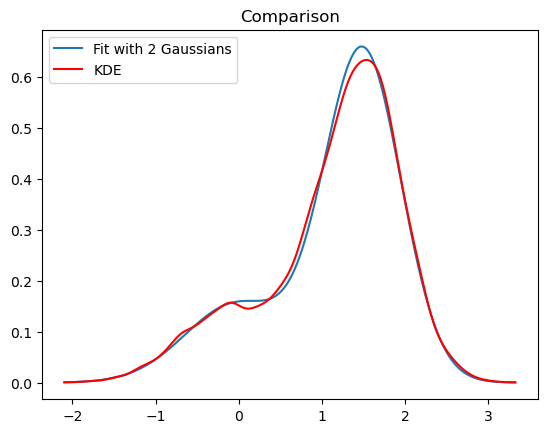

In [19]:
plt.plot(x, np.exp(gm.score_samples(x[:, np.newaxis])), label='Fit with 2 Gaussians')
plt.plot(x, np.exp(KDE.score_samples(x[:, np.newaxis])), label='KDE', color='red')
plt.legend()
plt.title('Comparison')
plt.show()

The fit made with KDE better represents the $T_{90}$ data. In fact the asymmetries in the distributions of the data can not be represented by a Gaussian distribution (which is symmetric).

I want now to compute the means and the standard deviations from the Gaussian Mixture analysis with two Gaussians.

In [20]:
means = gm.means_.flatten()
cov = gm.covariances_.flatten()
weights = gm.weights_.flatten()

dev = np.sqrt(cov)  # standard deviation from the variance

gauss1 = weights[0]*norm(means[0], dev[0]).pdf(x)
gauss2 = weights[1]*norm(means[1], dev[1]).pdf(x)

In [21]:
print('The means are: ', means[0], ' and ', means[1])
print('The standard deviations are: ', dev[0], ' and ', dev[1])
print('The weights are: ', weights[0], ' and ', weights[1])

The means are:  1.4868811218065896  and  -0.015155554129213102
The standard deviations are:  0.4619642361224909  and  0.628818375468372
The weights are:  0.7540814508495777  and  0.24591854915042238


And I plot the two components separetly, by considering also the result from KDE.

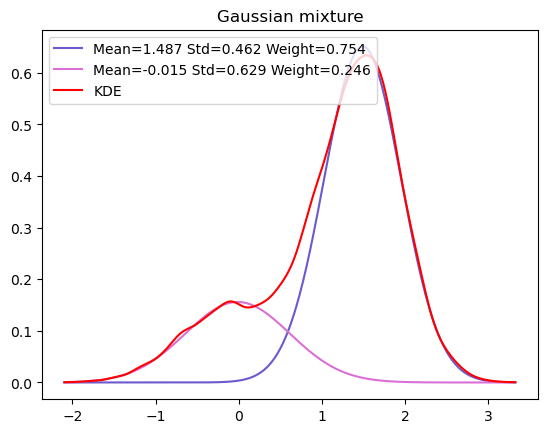

In [22]:
plt.plot(x, gauss1, label=f'Mean={means[0]:.3f} Std={dev[0]:.3f} Weight={weights[0]:.3f}', color='slateblue')
plt.plot(x, gauss2, label=f'Mean={means[1]:.3f} Std={dev[1]:.3f} Weight={weights[1]:.3f}', color='orchid')
plt.plot(x, np.exp(KDE.score_samples(x[:, np.newaxis])), label='KDE', color='red')
plt.legend(loc='upper left')
plt.title('Gaussian mixture')
plt.show()